In [21]:
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVD, accuracy, KNNBasic
from surprise.model_selection import train_test_split, cross_validate
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc, accuracy_score, precision_score, recall_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
# from lightfm import LightFM
# from lightfm.evaluation import precision_at_k, recall_at_k, auc_score

### 协同过滤

In [22]:
# 数据读取
ratings = pd.read_csv(r'./ml-1m/ratings.dat', sep='::', header=None, names=['UserID', 'MovieID', 'Rating', 'Timestamp'], engine='python')
movies = pd.read_csv(r'./ml-1m/movies.dat', sep='::', header=None, names=['MovieID', 'Title', 'Genres'], engine='python', encoding='ISO-8859-1')
users = pd.read_csv(r'./ml-1m/users.dat', sep='::', header=None, names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'], engine='python')
# 数据预处理
age_encoder = LabelEncoder()
occupation_encoder = LabelEncoder()
users['Age'] = age_encoder.fit_transform(users['Age'])
users['Occupation'] = occupation_encoder.fit_transform(users['Occupation'])
# 合并用户数据和评分数据
merged_data = pd.merge(ratings, users, on='UserID')
# 加载Surprise数据集
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(merged_data[['UserID', 'MovieID', 'Rating']], reader)
# 训练和测试数据集划分
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
# 使用KNNBasic进行协同过滤
svd = KNNBasic(sim_options={'user_based': True})  # user_based=True表示使用用户-用户协同过滤
# 训练模型
svd.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [39]:
user_id = 1
# 获取推荐结果并合并电影信息
test_predictions = svd.test(testset)
results = pd.DataFrame([(pred.uid, pred.iid, pred.est) for pred in test_predictions], columns=['UserID', 'MovieID', 'PredictedRating'])
# 合并电影信息
results = pd.merge(results, movies, on='MovieID')
results = results[['UserID', 'MovieID', 'Title', 'Genres', 'PredictedRating']]
results = results[results['UserID']==user_id]
results = results.drop_duplicates(subset='MovieID',keep='first')
# 按预测评分排序并展示前10个推荐结果
top_10_results = results.sort_values(by='PredictedRating', ascending=False).head(10)
top_10_results

,UserID,MovieID,Title,Genres,PredictedRating
1248,1,720,Wallace & Gromit: The Best of Aardman Animatio...,Animation,4.622470
134103,1,2918,Ferris Bueller's Day Off (1986),Comedy,4.491964
180419,1,1197,"Princess Bride, The (1987)",Action|Adventure|Comedy|Romance,4.325000
186245,1,1022,Cinderella (1950),Animation|Children's|Musical,4.298381
8040,1,594,Snow White and the Seven Dwarfs (1937),Animation|Children's|Musical,4.295740
17861,1,1962,Driving Miss Daisy (1989),Drama,4.065165
182218,1,2791,Airplane! (1980),Comedy,3.998299
58379,1,3408,Erin Brockovich (2000),Drama,3.827476
110121,1,1721,Titanic (1997),Drama|Romance,3.696379
94510,1,48,Pocahontas (1995),Animation|Children's|Musical|Romance,3.257143


Accuracy: 0.719138980814029
Precision: 0.7215688930019788
Recall: 0.8333521606520624
RMSE: 0.9231


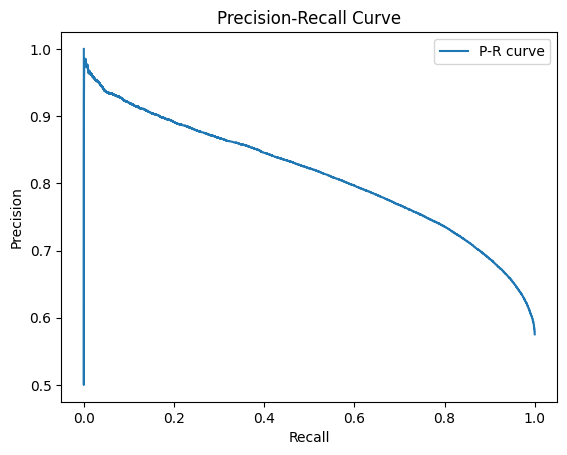

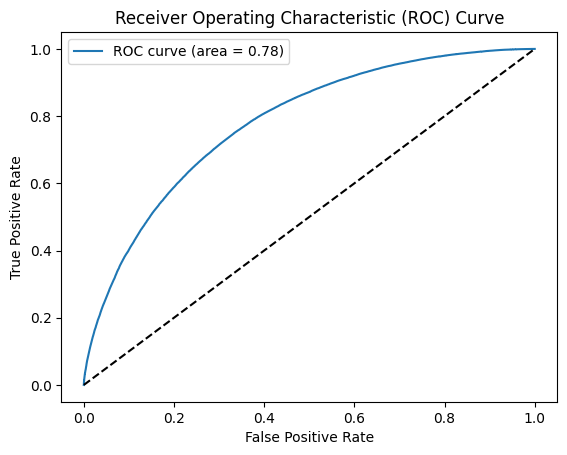

In [36]:
# 提取实际评分和预测评分
y_true = [pred.r_ui for pred in test_predictions]
y_pred = [pred.est for pred in test_predictions]
# 计算二分类的实际标签和预测标签
threshold = 3.5
y_true_binary = np.array([1 if rating >= threshold else 0 for rating in y_true])
y_pred_binary = np.array([1 if rating >= threshold else 0 for rating in y_pred])
# 计算准确率、精确率、召回率
accuracy_score = np.mean(y_true_binary == y_pred_binary)
precision = np.sum((y_true_binary == 1) & (y_pred_binary == 1)) / np.sum(y_pred_binary == 1)
recall = np.sum((y_true_binary == 1) & (y_pred_binary == 1)) / np.sum(y_true_binary == 1)
print(f'Accuracy: {accuracy_score}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
rmse = accuracy.rmse(test_predictions)
# 计算P-R曲线和ROC曲线
precision_vals, recall_vals, _ = precision_recall_curve(y_true_binary, y_pred)
fpr, tpr, _ = roc_curve(y_true_binary, y_pred)
roc_auc = auc(fpr, tpr)
# 绘制P-R曲线
plt.figure()
plt.plot(recall_vals, precision_vals, label='P-R curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()
# 绘制ROC曲线
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

### 矩阵分解

In [25]:
ratings = pd.read_csv('./ml-1m/ratings.dat', sep='::', header=None, names=['UserID', 'MovieID', 'Rating', 'Timestamp'], engine='python')
movies = pd.read_csv('./ml-1m/movies.dat', sep='::', header=None, names=['MovieID', 'Title', 'Genres'], engine='python', encoding='ISO-8859-1')
users = pd.read_csv('./ml-1m/users.dat', sep='::', header=None, names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'], engine='python')

In [26]:
from surprise import Dataset
# 加载数据到surprise库
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['UserID', 'MovieID', 'Rating']], reader)

In [27]:
# 划分训练集和测试集
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
# 使用SVD算法
algo = SVD()
# 训练模型
algo.fit(trainset)
predictions = algo.test(testset)

In [28]:
# 提取真实评分和预测评分
y_true = [pred.r_ui for pred in predictions]
y_pred = [pred.est for pred in predictions]
# 转换为二分类问题
y_true_binary = np.array([1 if x >= 3.5 else 0 for x in y_true])
y_pred_binary = np.array([1 if x >= 3.5 else 0 for x in y_pred])

In [29]:
# 将电影ID设置为索引以便快速查找
movies.set_index('MovieID', inplace=True)

In [30]:
# 给特定用户推荐N个电影，并显示电影的名字和类型
def get_top_n_recommendations(user_id, n=10):
    user_ratings = ratings[ratings['UserID'] == user_id]
    user_rated_items = set(user_ratings['MovieID'])
    all_items = set(ratings['MovieID'])
    items_to_predict = all_items - user_rated_items
    predictions = [algo.predict(user_id, item_id) for item_id in items_to_predict]
    recommendations = sorted(predictions, key=lambda x: x.est, reverse=True)
    top_n_recommendations = recommendations[:n]
    results = []
    for pred in top_n_recommendations:
        movie_id = pred.iid
        movie_title = movies.loc[movie_id]['Title']
        movie_genres = movies.loc[movie_id]['Genres']
        results.append((movie_id, movie_title, movie_genres, pred.est))
    return results
# 示例
user_id = 1
recommendations = get_top_n_recommendations(user_id, n=10)
print("Top 10 recommendations for user ID 1:")
for rec in recommendations:
    print(f"Movie ID: {rec[0]}, Title: {rec[1]}, Genres: {rec[2]}, Predicted Rating: {rec[3]}")

Top 10 recommendations for user ID 1:
Movie ID: 2905, Title: Sanjuro (1962), Genres: Action|Adventure, Predicted Rating: 4.991994510557895
Movie ID: 318, Title: Shawshank Redemption, The (1994), Genres: Drama, Predicted Rating: 4.913396111039537
Movie ID: 50, Title: Usual Suspects, The (1995), Genres: Crime|Thriller, Predicted Rating: 4.82549474844478
Movie ID: 668, Title: Pather Panchali (1955), Genres: Drama, Predicted Rating: 4.793873481099567
Movie ID: 1242, Title: Glory (1989), Genres: Action|Drama|War, Predicted Rating: 4.791870535039388
Movie ID: 1234, Title: Sting, The (1973), Genres: Comedy|Crime, Predicted Rating: 4.7854945770177695
Movie ID: 1250, Title: Bridge on the River Kwai, The (1957), Genres: Drama|War, Predicted Rating: 4.77464114978346
Movie ID: 2329, Title: American History X (1998), Genres: Drama, Predicted Rating: 4.774148081776849
Movie ID: 1203, Title: 12 Angry Men (1957), Genres: Drama, Predicted Rating: 4.755362504920231
Movie ID: 2019, Title: Seven Samurai (

Accuracy: 0.7391597764469462
Precision: 0.7666966284512584
Recall: 0.7856640105664706
RMSE: 0.8738


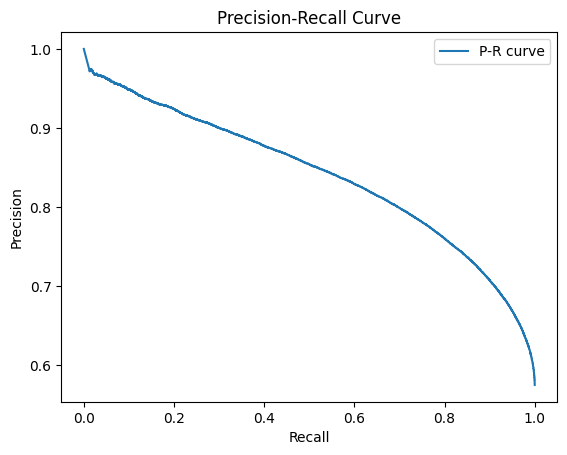

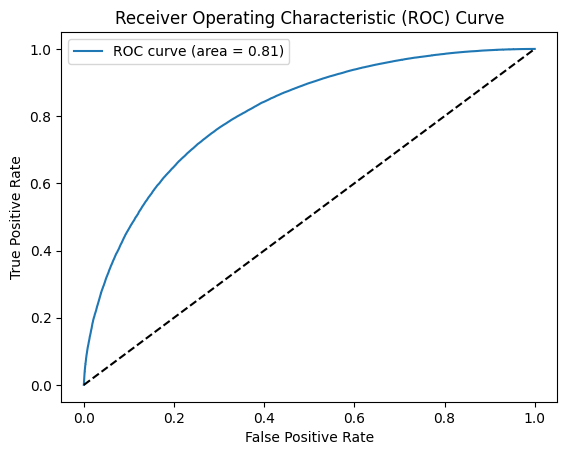

In [20]:
# 计算准确率、精确率、召回率
accuracy_score = np.mean(y_true_binary == y_pred_binary)
precision = np.sum((y_true_binary == 1) & (y_pred_binary == 1)) / np.sum(y_pred_binary == 1)
recall = np.sum((y_true_binary == 1) & (y_pred_binary == 1)) / np.sum(y_true_binary == 1)
print(f'Accuracy: {accuracy_score}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
# 计算RMSE
rmse = accuracy.rmse(predictions)
# 计算P-R曲线和ROC曲线
precision_vals, recall_vals, _ = precision_recall_curve(y_true_binary, y_pred)
fpr, tpr, _ = roc_curve(y_true_binary, y_pred)
roc_auc = auc(fpr, tpr)
# 绘制P-R曲线
plt.figure()
plt.plot(recall_vals, precision_vals, label='P-R curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()
# 绘制ROC曲线
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

RMSE: 1595248387679.1987
Accuracy: 0.4707301363780019
Precision: 0.5581311698173534
Recall: 0.3880891507336594


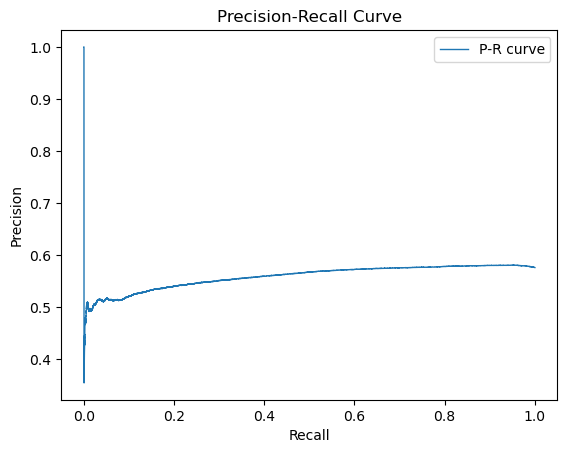

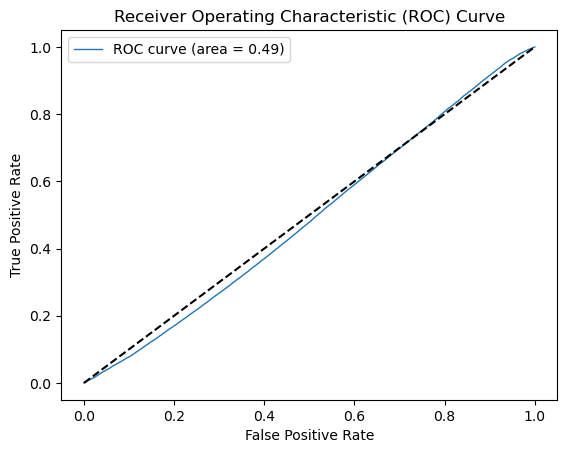

Top 10 recommendations for user ID 1:
Movie ID: 2, Title: Jumanji (1995), Genres: Adventure|Children's|Fantasy, Predicted Rating: -1196329.8396625444
Movie ID: 3, Title: Grumpier Old Men (1995), Genres: Comedy|Romance, Predicted Rating: -2149002.578644468
Movie ID: 4, Title: Waiting to Exhale (1995), Genres: Comedy|Drama, Predicted Rating: -3101675.317626392
Movie ID: 5, Title: Father of the Bride Part II (1995), Genres: Comedy, Predicted Rating: -4054348.0566083165
Movie ID: 6, Title: Heat (1995), Genres: Action|Crime|Thriller, Predicted Rating: -5007020.795590239
Movie ID: 7, Title: Sabrina (1995), Genres: Comedy|Romance, Predicted Rating: -5959693.534572163
Movie ID: 8, Title: Tom and Huck (1995), Genres: Adventure|Children's, Predicted Rating: -6912366.273554087
Movie ID: 9, Title: Sudden Death (1995), Genres: Action, Predicted Rating: -7865039.012536012
Movie ID: 10, Title: GoldenEye (1995), Genres: Action|Adventure|Thriller, Predicted Rating: -8817711.751517937
Movie ID: 11, Titl

In [9]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, precision_recall_curve, roc_curve, auc
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_extraction import DictVectorizer
import matplotlib.pyplot as plt
import numpy as np
from scipy import sparse

# 加载数据
ratings = pd.read_csv('./ml-1m/ratings.dat', sep='::', header=None, names=['UserID', 'MovieID', 'Rating', 'Timestamp'], engine='python')
movies = pd.read_csv('./ml-1m/movies.dat', sep='::', header=None, names=['MovieID', 'Title', 'Genres'], engine='python', encoding='ISO-8859-1')
users = pd.read_csv('./ml-1m/users.dat', sep='::', header=None, names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'], engine='python')

# 编码用户特征
user_id_enc = LabelEncoder()
users['UserID'] = user_id_enc.fit_transform(users['UserID'])

gender_enc = LabelEncoder()
users['Gender'] = gender_enc.fit_transform(users['Gender'])

age_enc = LabelEncoder()
users['Age'] = age_enc.fit_transform(users['Age'])

occupation_enc = LabelEncoder()
users['Occupation'] = occupation_enc.fit_transform(users['Occupation'])

# 删除邮政编码列（因为它是非数值数据）
users = users.drop(columns=['Zip-code'])

# 合并数据集
data = pd.merge(ratings, users, on='UserID')
data = pd.merge(data, movies, on='MovieID')

# 特征工程
data['UserID'] = data['UserID'].astype('category')
data['MovieID'] = data['MovieID'].astype('category')
data['Gender'] = data['Gender'].astype('category')
data['Age'] = data['Age'].astype('category')
data['Occupation'] = data['Occupation'].astype('category')
data['Genres'] = data['Genres'].astype('category')

# 转换为字典格式
data_dict = data[['UserID', 'MovieID', 'Gender', 'Age', 'Occupation', 'Genres']].to_dict(orient='records')

# 使用DictVectorizer转换数据
vec = DictVectorizer()
X = vec.fit_transform(data_dict)
y = data['Rating'].values

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# 使用StandardScaler标准化特征
scaler = StandardScaler(with_mean=False)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 使用PolynomialFeatures进行交互特征处理
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# 将数据转换为稀疏矩阵格式
X_train_poly = sparse.csr_matrix(X_train_poly)
X_test_poly = sparse.csr_matrix(X_test_poly)

# 训练SGDRegressor模型
reg = SGDRegressor(loss='squared_error', penalty='l2', max_iter=1000, tol=1e-3)
reg.fit(X_train_poly, y_train)

# 预测
y_pred = reg.predict(X_test_poly)

# 评估模型
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")

# 将预测值和真实值转换为二进制标签
threshold = 3.5
y_test_binary = np.array([1 if rating >= threshold else 0 for rating in y_test])
y_pred_binary = np.array([1 if pred >= threshold else 0 for pred in y_pred])

# 计算准确率、精确率和召回率
accuracy_score = np.mean(y_test_binary == y_pred_binary)
precision = np.sum((y_test_binary == 1) & (y_pred_binary == 1)) / np.sum(y_pred_binary == 1)
recall = np.sum((y_test_binary == 1) & (y_pred_binary == 1)) / np.sum(y_test_binary == 1)
print(f'Accuracy: {accuracy_score}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

# 计算P-R曲线和ROC曲线
precision_vals, recall_vals, _ = precision_recall_curve(y_test_binary, y_pred)
fpr, tpr, _ = roc_curve(y_test_binary, y_pred)
roc_auc = auc(fpr, tpr)

# 绘制P-R曲线
plt.figure()
plt.plot(recall_vals, precision_vals, label='P-R curve', linewidth=1, markersize=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# 绘制ROC曲线
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})', linewidth=1, markersize=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# 给特定用户推荐N个电影，并显示电影的名字和类型
def get_top_n_recommendations(user_id, n=10):
    # 获取用户已经评分的电影
    user_ratings = ratings[ratings['UserID'] == user_id]
    user_rated_items = set(user_ratings['MovieID'])
    # 获取所有电影的ID
    all_items = set(ratings['MovieID'])
    # 未评分的电影
    items_to_predict = all_items - user_rated_items
    # 预测未评分电影的评分
    items_to_predict_dicts = [{'UserID': user_id, 'MovieID': item_id} for item_id in items_to_predict]
    items_to_predict_features = vec.transform(items_to_predict_dicts)
    items_to_predict_poly = poly.transform(scaler.transform(items_to_predict_features))
    predictions = reg.predict(sparse.csr_matrix(items_to_predict_poly))
    # 按预测评分排序
    sorted_indices = np.argsort(predictions)[::-1]
    top_n_indices = sorted_indices[:n]
    top_n_movie_ids = [list(items_to_predict)[i] for i in top_n_indices]
    top_n_predictions = predictions[top_n_indices]
    # 获取推荐电影的名字和类型
    results = []
    for movie_id, est in zip(top_n_movie_ids, top_n_predictions):
        movie_title = movies[movies['MovieID'] == movie_id]['Title'].values[0]
        movie_genres = movies[movies['MovieID'] == movie_id]['Genres'].values[0]
        results.append((movie_id, movie_title, movie_genres, est))
    return results

# 示例：为用户ID为1的用户推荐10部电影
user_id = 1
recommendations = get_top_n_recommendations(user_id, n=10)
print("Top 10 recommendations for user ID 1:")
for rec in recommendations:
    print(f"Movie ID: {rec[0]}, Title: {rec[1]}, Genres: {rec[2]}, Predicted Rating: {rec[3]}")


In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_squared_error, precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

# 检查GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 加载数据
ratings = pd.read_csv('./ml-1m/ratings.dat', sep='::', header=None, names=['UserID', 'MovieID', 'Rating', 'Timestamp'], engine='python')
movies = pd.read_csv('./ml-1m/movies.dat', sep='::', header=None, names=['MovieID', 'Title', 'Genres'], engine='python', encoding='ISO-8859-1')
users = pd.read_csv('./ml-1m/users.dat', sep='::', header=None, names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'], engine='python')

# 编码用户特征
user_id_enc = LabelEncoder()
users['UserID'] = user_id_enc.fit_transform(users['UserID'])

gender_enc = LabelEncoder()
users['Gender'] = gender_enc.fit_transform(users['Gender'])

age_enc = LabelEncoder()
users['Age'] = age_enc.fit_transform(users['Age'])

occupation_enc = LabelEncoder()
users['Occupation'] = occupation_enc.fit_transform(users['Occupation'])

# 删除邮政编码列（因为它是非数值数据）
users = users.drop(columns=['Zip-code'])

# 合并数据集
data = pd.merge(ratings, users, on='UserID')
data = pd.merge(data, movies, on='MovieID')

# 编码电影特征
movie_id_enc = LabelEncoder()
data['MovieID'] = movie_id_enc.fit_transform(data['MovieID'])

# 将分类特征转换为数字编码
categorical_columns = ['UserID', 'MovieID', 'Gender', 'Age', 'Occupation']
for col in categorical_columns:
    data[col] = LabelEncoder().fit_transform(data[col])

# 特征和标签
X = data[categorical_columns].values
y = data['Rating'].values

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# 定义数据集类
class MovieLensDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = MovieLensDataset(X_train, y_train)
test_dataset = MovieLensDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [11]:
# 定义Deep Crossing模型
class DeepCrossing(nn.Module):
    def __init__(self, n_users, n_movies, n_genders, n_ages, n_occupations, embedding_dim=32):
        super(DeepCrossing, self).__init__()
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.movie_embedding = nn.Embedding(n_movies, embedding_dim)
        self.gender_embedding = nn.Embedding(n_genders, embedding_dim)
        self.age_embedding = nn.Embedding(n_ages, embedding_dim)
        self.occupation_embedding = nn.Embedding(n_occupations, embedding_dim)
        
        self.fc = nn.Sequential(
            nn.Linear(embedding_dim * len(categorical_columns), 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        user_emb = self.user_embedding(x[:, 0])
        movie_emb = self.movie_embedding(x[:, 1])
        gender_emb = self.gender_embedding(x[:, 2])
        age_emb = self.age_embedding(x[:, 3])
        occupation_emb = self.occupation_embedding(x[:, 4])
        
        x = torch.cat([user_emb, movie_emb, gender_emb, age_emb, occupation_emb], dim=-1)
        x = self.fc(x)
        return x

# 获取各个特征的类别数量
n_users = data['UserID'].nunique()
n_movies = data['MovieID'].nunique()
n_genders = data['Gender'].nunique()
n_ages = data['Age'].nunique()
n_occupations = data['Occupation'].nunique()

# 创建模型
model = DeepCrossing(n_users, n_movies, n_genders, n_ages, n_occupations).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
# 训练模型
n_epochs = 10
for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch).squeeze()
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(y_batch)
    
    train_loss /= len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{n_epochs}, Training Loss: {train_loss:.4f}')

Epoch 1/10, Training Loss: 0.9843
Epoch 2/10, Training Loss: 0.8405
Epoch 3/10, Training Loss: 0.8198
Epoch 4/10, Training Loss: 0.8071
Epoch 5/10, Training Loss: 0.7976
Epoch 6/10, Training Loss: 0.7895
Epoch 7/10, Training Loss: 0.7815
Epoch 8/10, Training Loss: 0.7732
Epoch 9/10, Training Loss: 0.7644
Epoch 10/10, Training Loss: 0.7552


RMSE: 0.8935343518165776
Accuracy: 0.7286081762792689
Precision: 0.7523796257603195
Recall: 0.7880446865273455


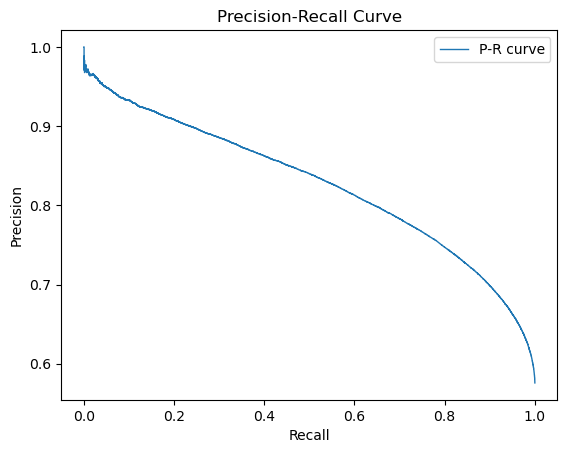

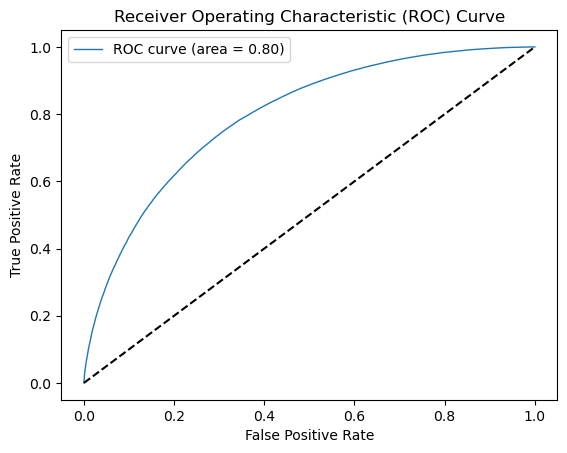

In [14]:
# 评估模型
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_batch_pred = model(X_batch).squeeze()
        y_pred.extend(y_batch_pred.cpu().tolist())
        y_true.extend(y_batch.cpu().tolist())

y_pred = np.array(y_pred)
y_true = np.array(y_true)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f'RMSE: {rmse}')

# 计算二分类评估指标
threshold = 3.5
y_true_binary = np.array([1 if rating >= threshold else 0 for rating in y_true])
y_pred_binary = np.array([1 if pred >= threshold else 0 for pred in y_pred])

accuracy = np.mean(y_true_binary == y_pred_binary)
precision = np.sum((y_true_binary == 1) & (y_pred_binary == 1)) / np.sum(y_pred_binary == 1)
recall = np.sum((y_true_binary == 1) & (y_pred_binary == 1)) / np.sum(y_true_binary == 1)
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

# 绘制P-R曲线和ROC曲线
precision_vals, recall_vals, _ = precision_recall_curve(y_true_binary, y_pred)
fpr, tpr, _ = roc_curve(y_true_binary, y_pred)
roc_auc = auc(fpr, tpr)

# 绘制P-R曲线
plt.figure()
plt.plot(recall_vals, precision_vals, label='P-R curve', linewidth=1, markersize=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# 绘制ROC曲线
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})', linewidth=1, markersize=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


In [15]:
# 给特定用户推荐N个电影，并显示电影的名字和类型
def get_top_n_recommendations(user_id, n=10):
    # 获取用户已经评分的电影
    user_ratings = ratings[ratings['UserID'] == user_id]
    user_rated_items = set(user_ratings['MovieID'])
    # 获取所有电影的ID
    all_items = set(ratings['MovieID'])
    # 未评分的电影
    items_to_predict = all_items - user_rated_items
    # 预测未评分电影的评分
    items_to_predict_dicts = [{'UserID': user_id, 'MovieID': item_id} for item_id in items_to_predict]
    items_to_predict_features = vec.transform(items_to_predict_dicts)
    items_to_predict_tensor = torch.tensor(items_to_predict_features.todense(), dtype=torch.long).to(device)
    with torch.no_grad():
        predictions = model(items_to_predict_tensor).squeeze().tolist()
    # 按预测评分排序
    sorted_indices = np.argsort(predictions)[::-1]
    top_n_indices = sorted_indices[:n]
    top_n_movie_ids = [list(items_to_predict)[i] for i in top_n_indices]
    top_n_predictions = np.array(predictions)[top_n_indices]
    # 获取推荐电影的名字和类型
    results = []
    for movie_id, est in zip(top_n_movie_ids, top_n_predictions):
        movie_title = movies[movies['MovieID'] == movie_id]['Title'].values[0]
        movie_genres = movies[movies['MovieID'] == movie_id]['Genres'].values[0]
        results.append((movie_id, movie_title, movie_genres, est))
    return results

# 示例：为用户ID为1的用户推荐10部电影
user_id = 1
recommendations = get_top_n_recommendations(user_id, n=10)
print("Top 10 recommendations for user ID 1:")
for rec in recommendations:
    print(f"Movie ID: {rec[0]}, Title: {rec[1]}, Genres: {rec[2]}, Predicted Rating: {rec[3]}")


Top 10 recommendations for user ID 1:
Movie ID: 3952, Title: Contender, The (2000), Genres: Drama|Thriller, Predicted Rating: 4.165019512176514
Movie ID: 1351, Title: Blood & Wine (1997), Genres: Drama, Predicted Rating: 4.165019512176514
Movie ID: 1349, Title: Nosferatu a Venezia (1986), Genres: Horror, Predicted Rating: 4.165019512176514
Movie ID: 1348, Title: Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922), Genres: Horror, Predicted Rating: 4.165019512176514
Movie ID: 1347, Title: Nightmare on Elm Street, A (1984), Genres: Horror, Predicted Rating: 4.165019512176514
Movie ID: 1346, Title: Cat People (1982), Genres: Horror, Predicted Rating: 4.165019512176514
Movie ID: 1345, Title: Carrie (1976), Genres: Horror, Predicted Rating: 4.165019512176514
Movie ID: 1344, Title: Cape Fear (1962), Genres: Film-Noir|Thriller, Predicted Rating: 4.165019512176514
Movie ID: 1343, Title: Cape Fear (1991), Genres: Thriller, Predicted Rating: 4.165019512176514
Movie ID: 1342, Title: Candyman

In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_squared_error, precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

# 检查GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 加载数据
ratings = pd.read_csv('./ml-1m/ratings.dat', sep='::', header=None, names=['UserID', 'MovieID', 'Rating', 'Timestamp'], engine='python')
movies = pd.read_csv('./ml-1m/movies.dat', sep='::', header=None, names=['MovieID', 'Title', 'Genres'], engine='python', encoding='ISO-8859-1')
users = pd.read_csv('./ml-1m/users.dat', sep='::', header=None, names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'], engine='python')

# 编码用户特征
user_id_enc = LabelEncoder()
users['UserID'] = user_id_enc.fit_transform(users['UserID'])

# 合并数据集
data = pd.merge(ratings, users, on='UserID')
data = pd.merge(data, movies, on='MovieID')

# 编码电影特征
movie_id_enc = LabelEncoder()
data['MovieID'] = movie_id_enc.fit_transform(data['MovieID'])

# 将分类特征转换为数字编码
categorical_columns = ['UserID', 'MovieID']
for col in categorical_columns:
    data[col] = LabelEncoder().fit_transform(data[col])

# 特征和标签
X = data[categorical_columns].values
y = data['Rating'].values

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# 定义数据集类
class MovieLensDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = MovieLensDataset(X_train, y_train)
test_dataset = MovieLensDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [17]:
# 定义NCF模型
class NCF(nn.Module):
    def __init__(self, n_users, n_movies, embedding_dim=32):
        super(NCF, self).__init__()
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.movie_embedding = nn.Embedding(n_movies, embedding_dim)
        
        self.fc_layers = nn.Sequential(
            nn.Linear(embedding_dim * 2, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        user_emb = self.user_embedding(x[:, 0])
        movie_emb = self.movie_embedding(x[:, 1])
        
        x = torch.cat([user_emb, movie_emb], dim=-1)
        x = self.fc_layers(x)
        return x

# 获取各个特征的类别数量
n_users = data['UserID'].nunique()
n_movies = data['MovieID'].nunique()

# 创建模型
model = NCF(n_users, n_movies).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [18]:
# 训练模型
n_epochs = 10
for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch).squeeze()
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(y_batch)
    
    train_loss /= len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{n_epochs}, Training Loss: {train_loss:.4f}')


Epoch 1/10, Training Loss: 1.0011
Epoch 2/10, Training Loss: 0.8513
Epoch 3/10, Training Loss: 0.8310
Epoch 4/10, Training Loss: 0.8191
Epoch 5/10, Training Loss: 0.8097
Epoch 6/10, Training Loss: 0.8009
Epoch 7/10, Training Loss: 0.7917
Epoch 8/10, Training Loss: 0.7823
Epoch 9/10, Training Loss: 0.7728
Epoch 10/10, Training Loss: 0.7633


RMSE: 0.9099428955116378
Accuracy: 0.7163665603859709
Precision: 0.7596944979768313
Recall: 0.7421979212983548


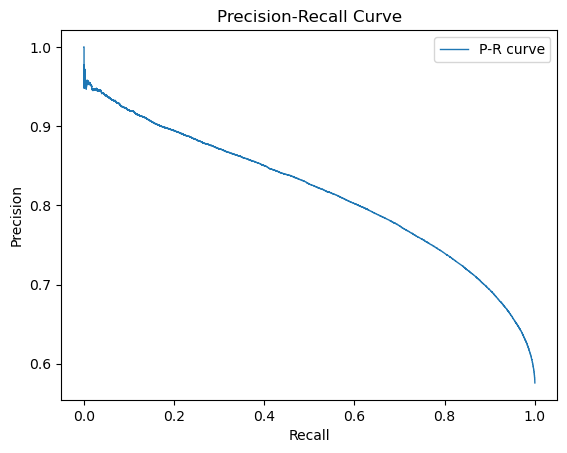

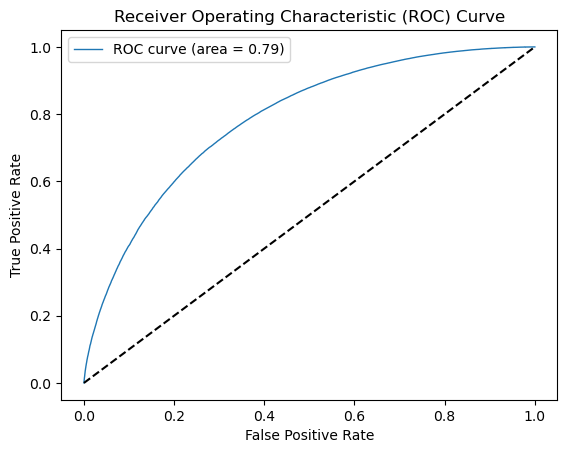

In [19]:
# 评估模型
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_batch_pred = model(X_batch).squeeze()
        y_pred.extend(y_batch_pred.cpu().tolist())
        y_true.extend(y_batch.cpu().tolist())

y_pred = np.array(y_pred)
y_true = np.array(y_true)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f'RMSE: {rmse}')

# 计算二分类评估指标
threshold = 3.5
y_true_binary = np.array([1 if rating >= threshold else 0 for rating in y_true])
y_pred_binary = np.array([1 if pred >= threshold else 0 for pred in y_pred])

accuracy = np.mean(y_true_binary == y_pred_binary)
precision = np.sum((y_true_binary == 1) & (y_pred_binary == 1)) / np.sum(y_pred_binary == 1)
recall = np.sum((y_true_binary == 1) & (y_pred_binary == 1)) / np.sum(y_true_binary == 1)
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

# 绘制P-R曲线和ROC曲线
precision_vals, recall_vals, _ = precision_recall_curve(y_true_binary, y_pred)
fpr, tpr, _ = roc_curve(y_true_binary, y_pred)
roc_auc = auc(fpr, tpr)

# 绘制P-R曲线
plt.figure()
plt.plot(recall_vals, precision_vals, label='P-R curve', linewidth=1, markersize=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# 绘制ROC曲线
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})', linewidth=1, markersize=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


In [20]:
# 给特定用户推荐N个电影，并显示电影的名字和类型
def get_top_n_recommendations(user_id, n=10):
    # 获取用户已经评分的电影
    user_ratings = ratings[ratings['UserID'] == user_id]
    user_rated_items = set(user_ratings['MovieID'])
    # 获取所有电影的ID
    all_items = set(ratings['MovieID'])
    # 未评分的电影
    items_to_predict = all_items - user_rated_items
    # 预测未评分电影的评分
    items_to_predict_list = [{'UserID': user_id, 'MovieID': item_id} for item_id in items_to_predict]
    items_to_predict_df = pd.DataFrame(items_to_predict_list)
    items_to_predict_df['UserID'] = user_id_enc.transform(items_to_predict_df['UserID'])
    items_to_predict_df['MovieID'] = movie_id_enc.transform(items_to_predict_df['MovieID'])
    items_to_predict_tensor = torch.tensor(items_to_predict_df.values, dtype=torch.long).to(device)
    with torch.no_grad():
        predictions = model(items_to_predict_tensor).squeeze().tolist()
    # 按预测评分排序
    sorted_indices = np.argsort(predictions)[::-1]
    top_n_indices = sorted_indices[:n]
    top_n_movie_ids = [list(items_to_predict)[i] for i in top_n_indices]
    top_n_predictions = np.array(predictions)[top_n_indices]
    # 获取推荐电影的名字和类型
    results = []
    for movie_id, est in zip(top_n_movie_ids, top_n_predictions):
        movie_title = movies[movies['MovieID'] == movie_id]['Title'].values[0]
        movie_genres = movies[movies['MovieID'] == movie_id]['Genres'].values[0]
        results.append((movie_id, movie_title, movie_genres, est))
    return results

# 示例：为用户ID为1的用户推荐10部电影
user_id = 1
recommendations = get_top_n_recommendations(user_id, n=10)
print("Top 10 recommendations for user ID 1:")
for rec in recommendations:
    print(f"Movie ID: {rec[0]}, Title: {rec[1]}, Genres: {rec[2]}, Predicted Rating: {rec[3]}")


Top 10 recommendations for user ID 1:
Movie ID: 2351, Title: Nights of Cabiria (Le Notti di Cabiria) (1957), Genres: Drama, Predicted Rating: 5.129437446594238
Movie ID: 904, Title: Rear Window (1954), Genres: Mystery|Thriller, Predicted Rating: 5.1132073402404785
Movie ID: 2503, Title: Apple, The (Sib) (1998), Genres: Drama, Predicted Rating: 5.07508659362793
Movie ID: 50, Title: Usual Suspects, The (1995), Genres: Crime|Thriller, Predicted Rating: 5.068849086761475
Movie ID: 1178, Title: Paths of Glory (1957), Genres: Drama|War, Predicted Rating: 5.017765998840332
Movie ID: 1240, Title: Terminator, The (1984), Genres: Action|Sci-Fi|Thriller, Predicted Rating: 4.977431297302246
Movie ID: 1189, Title: Thin Blue Line, The (1988), Genres: Documentary, Predicted Rating: 4.954192161560059
Movie ID: 1901, Title: Dear Jesse (1997), Genres: Documentary, Predicted Rating: 4.942811012268066
Movie ID: 1147, Title: When We Were Kings (1996), Genres: Documentary, Predicted Rating: 4.93674421310424

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_squared_error, precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

# 加载数据
ratings = pd.read_csv('./ml-1m/ratings.dat', sep='::', header=None, names=['UserID', 'MovieID', 'Rating', 'Timestamp'], engine='python')
movies = pd.read_csv('./ml-1m/movies.dat', sep='::', header=None, names=['MovieID', 'Title', 'Genres'], engine='python', encoding='ISO-8859-1')
users = pd.read_csv('./ml-1m/users.dat', sep='::', header=None, names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'], engine='python')

# 编码用户特征
user_id_enc = LabelEncoder()
users['UserID'] = user_id_enc.fit_transform(users['UserID'])

gender_enc = LabelEncoder()
users['Gender'] = gender_enc.fit_transform(users['Gender'])

age_enc = LabelEncoder()
users['Age'] = age_enc.fit_transform(users['Age'])

occupation_enc = LabelEncoder()
users['Occupation'] = occupation_enc.fit_transform(users['Occupation'])

# 分割电影类别
movies['Genres'] = movies['Genres'].apply(lambda x: x.split('|'))

# 对电影类别进行one-hot编码
mlb = MultiLabelBinarizer()
genre_enc = mlb.fit_transform(movies['Genres'])
genre_columns = [f"Genre_{genre}" for genre in mlb.classes_]
genre_df = pd.DataFrame(genre_enc, columns=genre_columns)

# 合并电影类别编码
movies = pd.concat([movies, genre_df], axis=1)

# 编码电影特征
movie_id_enc = LabelEncoder()
movies['MovieID'] = movie_id_enc.fit_transform(movies['MovieID'])

# 合并数据集
data = pd.merge(ratings, users, on='UserID')
data = pd.merge(data, movies, on='MovieID')
# 将分类特征转换为数字编码
categorical_columns = ['UserID', 'MovieID', 'Gender', 'Age', 'Occupation']
for col in categorical_columns:
    data[col] = LabelEncoder().fit_transform(data[col])

# 添加类别特征列
feature_columns = categorical_columns + genre_columns

# 特征和标签
X = data[feature_columns].values
y = data['Rating'].values

# 确保所有特征的最大值都在嵌入矩阵范围内
n_features = max(X.flatten()) + 1

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


# 定义数据集类
class MovieLensDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)  # 确保数据类型为long
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = MovieLensDataset(X_train, y_train)
test_dataset = MovieLensDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [2]:
# 定义FM模型
class FactorizationMachine(nn.Module):
    def __init__(self, n_features, k=10):
        super(FactorizationMachine, self).__init__()
        self.n_features = n_features
        self.k = k
        
        self.linear = nn.Embedding(n_features, 1)
        self.v = nn.Embedding(n_features, k)
        
        nn.init.xavier_uniform_(self.linear.weight)
        nn.init.xavier_uniform_(self.v.weight)
    
    def forward(self, x):
        linear_part = torch.sum(self.linear(x), dim=1)
        interactions = 0.5 * torch.sum(
            torch.pow(torch.sum(self.v(x), dim=1), 2) - torch.sum(torch.pow(self.v(x), 2), dim=1),
            dim=1,
            keepdim=True
        )
        output = linear_part + interactions
        return output.squeeze()

model = FactorizationMachine(n_features=n_features, k=10)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [3]:
# 训练模型
n_epochs = 10
for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch).squeeze()
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(y_batch)
    
    train_loss /= len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{n_epochs}, Training Loss: {train_loss:.4f}')

Epoch 1/10, Training Loss: 0.9784
Epoch 2/10, Training Loss: 0.9018
Epoch 3/10, Training Loss: 0.8550
Epoch 4/10, Training Loss: 0.8286
Epoch 5/10, Training Loss: 0.8092
Epoch 6/10, Training Loss: 0.7954
Epoch 7/10, Training Loss: 0.7840
Epoch 8/10, Training Loss: 0.7755
Epoch 9/10, Training Loss: 0.7687
Epoch 10/10, Training Loss: 0.7636


RMSE: 0.9257390529222271
Accuracy: 0.7141150401401373
Precision: 0.7417747297579791
Recall: 0.7717294456877863


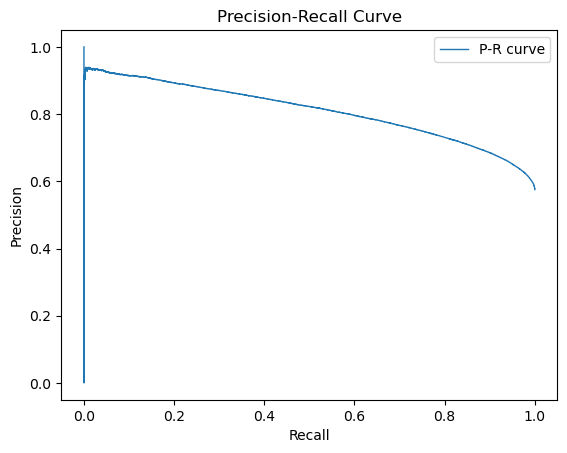

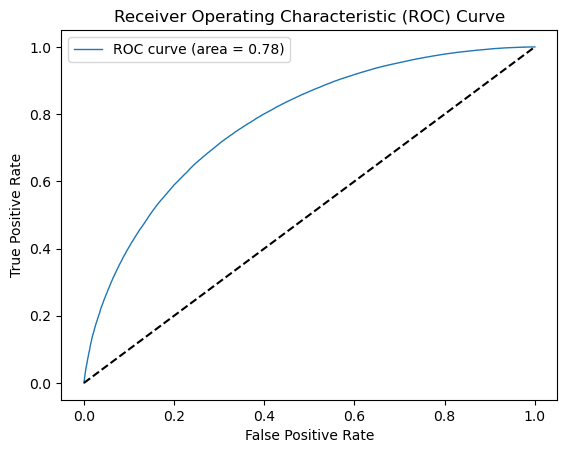

In [4]:
# 评估模型
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_batch_pred = model(X_batch).squeeze()
        y_pred.extend(y_batch_pred.tolist())
        y_true.extend(y_batch.tolist())

y_pred = np.array(y_pred)
y_true = np.array(y_true)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f'RMSE: {rmse}')

# 计算二分类评估指标
threshold = 3.5
y_true_binary = np.array([1 if rating >= threshold else 0 for rating in y_true])
y_pred_binary = np.array([1 if pred >= threshold else 0 for pred in y_pred])

accuracy = np.mean(y_true_binary == y_pred_binary)
precision = np.sum((y_true_binary == 1) & (y_pred_binary == 1)) / np.sum(y_pred_binary == 1)
recall = np.sum((y_true_binary == 1) & (y_pred_binary == 1)) / np.sum(y_true_binary == 1)
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

# 绘制P-R曲线和ROC曲线
precision_vals, recall_vals, _ = precision_recall_curve(y_true_binary, y_pred)
fpr, tpr, _ = roc_curve(y_true_binary, y_pred)
roc_auc = auc(fpr, tpr)

# 绘制P-R曲线
plt.figure()
plt.plot(recall_vals, precision_vals, label='P-R curve', linewidth=1, markersize=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# 绘制ROC曲线
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})', linewidth=1, markersize=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [10]:
import torch
import numpy as np
import pandas as pd

def get_top_n_recommendations(user_id, n=10):
    # 获取用户已经评分的电影
    user_ratings = ratings[ratings['UserID'] == user_id]
    user_rated_items = set(user_ratings['MovieID'])
    
    # 获取所有电影的ID
    all_items = set(ratings['MovieID'])
    
    # 未评分的电影
    items_to_predict = all_items - user_rated_items
    
    # 预测未评分电影的评分
    items_to_predict_list = [{'UserID': user_id, 'MovieID': item_id} for item_id in items_to_predict]
    items_to_predict_df = pd.DataFrame(items_to_predict_list)
    items_to_predict_df['UserID'] = user_id_enc.transform(items_to_predict_df['UserID'])
    items_to_predict_df['MovieID'] = movie_id_enc.transform(items_to_predict_df['MovieID'])
    
    # 创建特征矩阵
    user_features = users.loc[users['UserID'] == items_to_predict_df['UserID'].values[0], ['Gender', 'Age', 'Occupation']].values[0]
    movie_features = movies.loc[movies['MovieID'].isin(items_to_predict_df['MovieID']), genre_columns].values
    
    feature_matrix = np.hstack([
        items_to_predict_df[['UserID', 'MovieID']].values,
        np.tile(user_features, (len(items_to_predict_df), 1)),
        movie_features
    ])
    
    # 转换为张量
    feature_tensor = torch.tensor(feature_matrix, dtype=torch.long)
    
    # 预测评分
    model.eval()
    with torch.no_grad():
        predictions = model(feature_tensor).squeeze().tolist()
    
    # 按预测评分排序
    sorted_indices = np.argsort(predictions)[::-1]
    top_n_indices = sorted_indices[:n]
    top_n_movie_ids = [list(items_to_predict)[i] for i in top_n_indices]
    top_n_predictions = np.array(predictions)[top_n_indices]
    
    # 获取推荐电影的名字和类型
    results = []
    for movie_id, est in zip(top_n_movie_ids, top_n_predictions):
        movie_title = movies[movies['MovieID'] == movie_id]['Title'].values[0]
        movie_genres = movies[movies['MovieID'] == movie_id]['Genres'].values[0]
        results.append((movie_id, movie_title, movie_genres, est))
    
    return results

# 示例：为用户ID为1的用户推荐10部电影
user_id = 1
recommendations = get_top_n_recommendations(user_id, n=10)
print("Top 10 recommendations for user ID 1:")
for rec in recommendations:
    print(f"Movie ID: {rec[0]}, Title: {rec[1]}, Genres: {rec[2]}, Predicted Rating: {rec[3]}")


Top 10 recommendations for user ID 1:
Movie ID: 1827, Title: Cousin Bette (1998), Genres: ['Comedy'], Predicted Rating: 5.089200019836426
Movie ID: 1210, Title: Raging Bull (1980), Genres: ['Drama'], Predicted Rating: 4.820842266082764
Movie ID: 610, Title: Loaded (1994), Genres: ['Drama', 'Thriller'], Predicted Rating: 4.6937432289123535
Movie ID: 519, Title: Ruby in Paradise (1993), Genres: ['Drama'], Predicted Rating: 4.679162502288818
Movie ID: 3306, Title: Destination Moon (1950), Genres: ['Sci-Fi'], Predicted Rating: 4.652078628540039
Movie ID: 546, Title: Threesome (1994), Genres: ['Comedy', 'Romance'], Predicted Rating: 4.6219305992126465
Movie ID: 1174, Title: Madonna: Truth or Dare (1991), Genres: ['Documentary'], Predicted Rating: 4.61465311050415
Movie ID: 517, Title: Romeo Is Bleeding (1993), Genres: ['Crime', 'Thriller'], Predicted Rating: 4.609647750854492
Movie ID: 2931, Title: Princess Mononoke, The (Mononoke Hime) (1997), Genres: ['Action', 'Adventure', 'Animation'], 